In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import TensorDataset, DataLoader

In [2]:
# Set random seed for numpy
np.random.seed(11)
# Set random seed for pytorch
torch.manual_seed(11)
# Set random seed for pytorch running in GPU
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(11)

In [3]:
# Choose batch size
batch_size = 256

In [4]:
# Load processed data
UCI_train_features = np.load('./UCI_train_features.npy', allow_pickle=True)
UCI_train_labels = np.load('./UCI_train_labels.npy', allow_pickle=True)
UCI_test_features = np.load('./UCI_test_features.npy', allow_pickle=True)
UCI_test_labels = np.load('./UCI_test_labels.npy', allow_pickle=True)

# Subtract 1 for every label for correct training, i.e., [1,2,3,4,5,6] to [0,1,2,3,4,5]
UCI_train_labels = UCI_train_labels.astype(int) - 1
UCI_test_labels = UCI_test_labels.astype(int) - 1

In [5]:
# Transform to torch tensor
tensor_UCI_train_features = torch.Tensor(UCI_train_features) 
tensor_UCI_train_labels = torch.Tensor(UCI_train_labels)
tensor_UCI_test_features = torch.Tensor(UCI_test_features) 
tensor_UCI_test_labels = torch.Tensor(UCI_test_labels)
# Add one dimension of channel
tensor_UCI_train_features = torch.unsqueeze(tensor_UCI_train_features, 1)
tensor_UCI_test_features = torch.unsqueeze(tensor_UCI_test_features, 1)
# Create datset
train_dataset_UCI = TensorDataset(tensor_UCI_train_features,tensor_UCI_train_labels)
test_dataset_UCI = TensorDataset(tensor_UCI_test_features,tensor_UCI_test_labels)


In [6]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset_UCI, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset_UCI, batch_size=batch_size, shuffle=False)

In [7]:
print(len(train_loader.dataset))
print(len(test_loader.dataset))

7352
2947


In [8]:
for i, (images, labels) in enumerate(train_loader):
    print(images.shape)
    print(labels)
    break

torch.Size([256, 1, 36, 128])
tensor([5., 2., 5., 4., 1., 5., 1., 3., 0., 4., 4., 4., 5., 4., 5., 0., 2., 1.,
        4., 0., 4., 1., 2., 0., 5., 5., 0., 4., 5., 1., 4., 1., 5., 0., 5., 4.,
        3., 2., 4., 0., 3., 4., 5., 1., 4., 3., 4., 1., 3., 0., 3., 4., 0., 2.,
        4., 4., 5., 0., 1., 5., 1., 3., 5., 4., 5., 5., 2., 1., 1., 3., 0., 3.,
        3., 5., 5., 0., 4., 1., 1., 3., 4., 0., 5., 1., 3., 3., 5., 1., 5., 3.,
        3., 3., 3., 3., 2., 3., 0., 2., 4., 4., 2., 4., 5., 1., 5., 4., 3., 2.,
        2., 1., 4., 1., 2., 2., 3., 2., 3., 5., 5., 2., 5., 5., 0., 0., 2., 5.,
        5., 2., 0., 3., 5., 2., 4., 2., 5., 2., 4., 2., 0., 4., 3., 5., 2., 4.,
        5., 2., 5., 1., 3., 5., 3., 0., 1., 1., 5., 0., 5., 5., 3., 2., 1., 5.,
        0., 0., 0., 5., 4., 3., 2., 2., 0., 0., 4., 3., 4., 2., 3., 4., 3., 3.,
        4., 4., 3., 1., 5., 4., 5., 0., 3., 3., 5., 0., 4., 0., 0., 1., 3., 1.,
        1., 3., 3., 3., 2., 1., 1., 3., 1., 5., 1., 5., 0., 5., 1., 3., 2., 3.,
        5.

The first CNN architecture is: 32C5$\times$5-S2$\times$2-64C5$\times$5-S2$\times$2

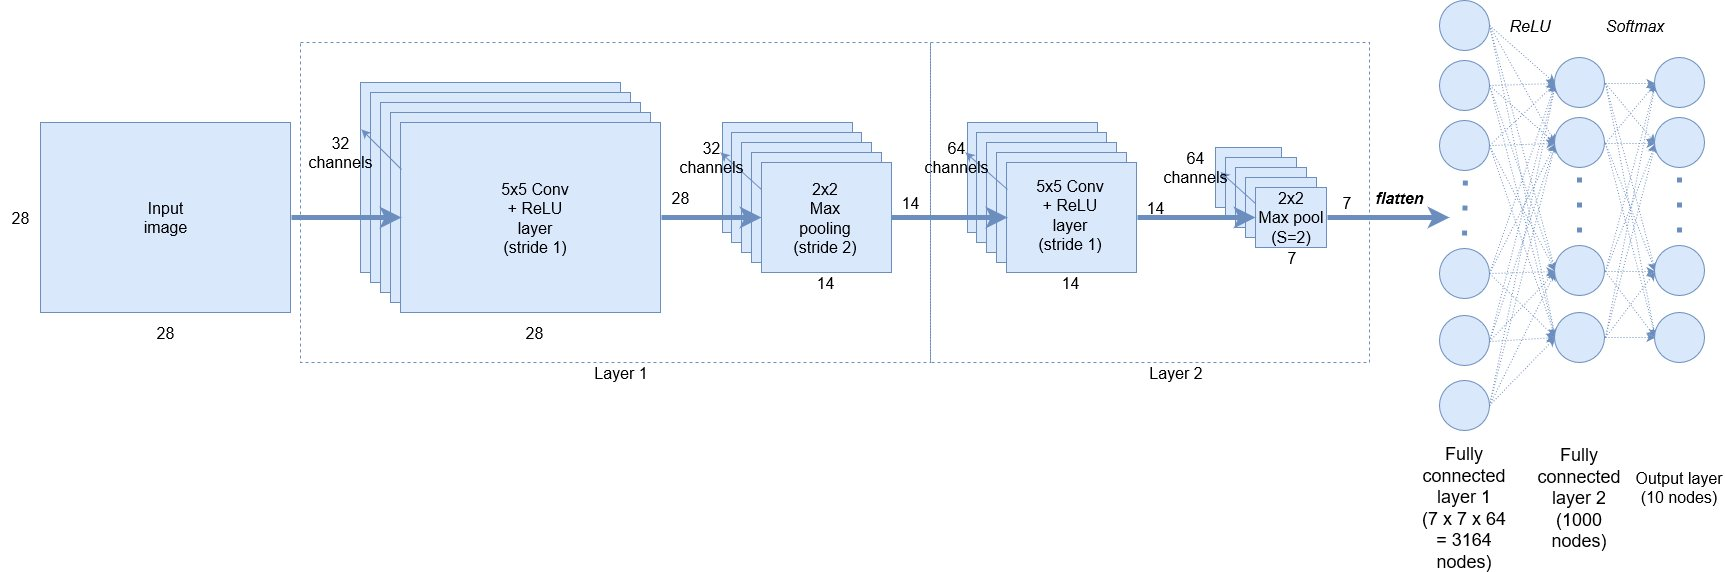

In [9]:
# Layers parameters:
original_image_length = 36
original_image_width = 128
max_pool1_kernel_size = 2
max_pool2_kernel_size = 2
final_image_length = int(original_image_length / max_pool1_kernel_size / max_pool2_kernel_size)
final_image_width = int(original_image_width / max_pool1_kernel_size / max_pool2_kernel_size)
channels_L1 = 32
channels_L2 = 64
nodes_FC1 = 1000
nodes_FC2 = 6 # The number should equal to the number of label types !!!

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, channels_L1, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = max_pool1_kernel_size, stride = 2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(channels_L1, channels_L2, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = max_pool2_kernel_size, stride = 2))
        self.drop_out = nn.Dropout()
        self.fc1 = nn.Linear(final_image_length * final_image_width * channels_L2, nodes_FC1)
        self.fc2 = nn.Linear(nodes_FC1, nodes_FC2)
    
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.drop_out(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

In [10]:
# Choose CPU or GPU
# model = ConvNet() #CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = ConvNet().to(device) #GPU

# Hyperparameter
num_epochs = 80
learning_rate = 0.00001

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [11]:
# Train the model on GPU
total_step = len(train_loader)
loss_list = []
acc_list = []
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # Run the forward pass
        outputs = model(images.to(device))
        loss = criterion(outputs, labels.to(device).long())
        loss_list.append(loss.item())

        # Backprop and perform Adam optimisation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Track the accuracy
        total = labels.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels.to(device).long()).sum().item()
        acc_list.append(correct / total)

        if (i + 1) % 10 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
                  .format(epoch + 1, num_epochs, i + 1, total_step, loss.item(),
                          (correct / total) * 100))

Epoch [1/80], Step [10/29], Loss: 1.8122, Accuracy: 44.53%
Epoch [1/80], Step [20/29], Loss: 1.4445, Accuracy: 59.38%
Epoch [2/80], Step [10/29], Loss: 1.0246, Accuracy: 62.11%
Epoch [2/80], Step [20/29], Loss: 0.5881, Accuracy: 75.39%
Epoch [3/80], Step [10/29], Loss: 0.6862, Accuracy: 75.39%
Epoch [3/80], Step [20/29], Loss: 0.5930, Accuracy: 79.30%
Epoch [4/80], Step [10/29], Loss: 0.4870, Accuracy: 84.38%
Epoch [4/80], Step [20/29], Loss: 0.4354, Accuracy: 82.42%
Epoch [5/80], Step [10/29], Loss: 0.3766, Accuracy: 84.77%
Epoch [5/80], Step [20/29], Loss: 0.4466, Accuracy: 82.42%
Epoch [6/80], Step [10/29], Loss: 0.3011, Accuracy: 87.50%
Epoch [6/80], Step [20/29], Loss: 0.2576, Accuracy: 90.62%
Epoch [7/80], Step [10/29], Loss: 0.3588, Accuracy: 88.28%
Epoch [7/80], Step [20/29], Loss: 0.2419, Accuracy: 87.89%
Epoch [8/80], Step [10/29], Loss: 0.2371, Accuracy: 92.19%
Epoch [8/80], Step [20/29], Loss: 0.2464, Accuracy: 91.02%
Epoch [9/80], Step [10/29], Loss: 0.2464, Accuracy: 90.2

Epoch [69/80], Step [20/29], Loss: 0.0961, Accuracy: 96.88%
Epoch [70/80], Step [10/29], Loss: 0.1136, Accuracy: 94.53%
Epoch [70/80], Step [20/29], Loss: 0.0859, Accuracy: 96.09%
Epoch [71/80], Step [10/29], Loss: 0.0660, Accuracy: 97.27%
Epoch [71/80], Step [20/29], Loss: 0.0494, Accuracy: 98.05%
Epoch [72/80], Step [10/29], Loss: 0.0647, Accuracy: 96.88%
Epoch [72/80], Step [20/29], Loss: 0.0588, Accuracy: 98.05%
Epoch [73/80], Step [10/29], Loss: 0.1163, Accuracy: 95.70%
Epoch [73/80], Step [20/29], Loss: 0.0730, Accuracy: 96.88%
Epoch [74/80], Step [10/29], Loss: 0.0510, Accuracy: 98.05%
Epoch [74/80], Step [20/29], Loss: 0.0740, Accuracy: 97.27%
Epoch [75/80], Step [10/29], Loss: 0.0675, Accuracy: 96.88%
Epoch [75/80], Step [20/29], Loss: 0.0736, Accuracy: 96.88%
Epoch [76/80], Step [10/29], Loss: 0.0872, Accuracy: 95.70%
Epoch [76/80], Step [20/29], Loss: 0.0929, Accuracy: 95.70%
Epoch [77/80], Step [10/29], Loss: 0.0846, Accuracy: 96.88%
Epoch [77/80], Step [20/29], Loss: 0.078

In [12]:
# Test the model on GPU
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        outputs = model(images.to(device))
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels.to(device)).sum().item()

    print('Test Accuracy of the model on the test images: {} %'.format((correct / total) * 100))

Test Accuracy of the model on the test images: 93.51883271123175 %


The second CNN architecture is: 5C5$\times$5-S2$\times$2-10C5$\times$5-S2$\times$2

In [13]:
# Layers parameters:
original_image_length = 36
original_image_width = 128
max_pool1_kernel_size = 2
max_pool2_kernel_size = 2
final_image_length = 6
final_image_width = 29
channels_L1 = 5
channels_L2 = 10
nodes_FC1 = 1000
nodes_FC2 = 6 # The number should equal to the number of label types !!!

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, channels_L1, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = max_pool1_kernel_size))
        self.layer2 = nn.Sequential(
            nn.Conv2d(channels_L1, channels_L2, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = max_pool2_kernel_size))
        self.drop_out = nn.Dropout()
        self.fc1 = nn.Linear(final_image_length * final_image_width * channels_L2, nodes_FC1)
        self.fc2 = nn.Linear(nodes_FC1, nodes_FC2)
    
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.drop_out(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

In [14]:
# Choose CPU or GPU
# model = ConvNet() #CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = ConvNet().to(device) #GPU

# Hyperparameter
num_epochs = 200
learning_rate = 0.00001

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [15]:
# Train the model on GPU
total_step = len(train_loader)
loss_list = []
acc_list = []
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # Run the forward pass
        outputs = model(images.to(device))
        loss = criterion(outputs, labels.to(device).long())
        loss_list.append(loss.item())

        # Backprop and perform Adam optimisation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Track the accuracy
        total = labels.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels.to(device).long()).sum().item()
        acc_list.append(correct / total)

        if (i + 1) % 10 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
                  .format(epoch + 1, num_epochs, i + 1, total_step, loss.item(),
                          (correct / total) * 100))

Epoch [1/200], Step [10/29], Loss: 2.4695, Accuracy: 24.22%
Epoch [1/200], Step [20/29], Loss: 2.1564, Accuracy: 25.78%
Epoch [2/200], Step [10/29], Loss: 1.7136, Accuracy: 37.50%
Epoch [2/200], Step [20/29], Loss: 1.6022, Accuracy: 41.80%
Epoch [3/200], Step [10/29], Loss: 1.3718, Accuracy: 50.78%
Epoch [3/200], Step [20/29], Loss: 1.3025, Accuracy: 48.44%
Epoch [4/200], Step [10/29], Loss: 1.2337, Accuracy: 52.73%
Epoch [4/200], Step [20/29], Loss: 1.1511, Accuracy: 51.56%
Epoch [5/200], Step [10/29], Loss: 1.2307, Accuracy: 49.61%
Epoch [5/200], Step [20/29], Loss: 1.2118, Accuracy: 51.95%
Epoch [6/200], Step [10/29], Loss: 1.0866, Accuracy: 50.39%
Epoch [6/200], Step [20/29], Loss: 1.0078, Accuracy: 59.77%
Epoch [7/200], Step [10/29], Loss: 0.9623, Accuracy: 60.94%
Epoch [7/200], Step [20/29], Loss: 0.9996, Accuracy: 54.69%
Epoch [8/200], Step [10/29], Loss: 0.9167, Accuracy: 64.45%
Epoch [8/200], Step [20/29], Loss: 0.8544, Accuracy: 62.50%
Epoch [9/200], Step [10/29], Loss: 0.865

Epoch [68/200], Step [20/29], Loss: 0.3343, Accuracy: 87.11%
Epoch [69/200], Step [10/29], Loss: 0.3498, Accuracy: 84.77%
Epoch [69/200], Step [20/29], Loss: 0.2983, Accuracy: 87.89%
Epoch [70/200], Step [10/29], Loss: 0.4127, Accuracy: 82.81%
Epoch [70/200], Step [20/29], Loss: 0.3929, Accuracy: 84.38%
Epoch [71/200], Step [10/29], Loss: 0.2794, Accuracy: 91.02%
Epoch [71/200], Step [20/29], Loss: 0.3739, Accuracy: 83.59%
Epoch [72/200], Step [10/29], Loss: 0.3409, Accuracy: 88.28%
Epoch [72/200], Step [20/29], Loss: 0.3017, Accuracy: 88.67%
Epoch [73/200], Step [10/29], Loss: 0.3586, Accuracy: 87.11%
Epoch [73/200], Step [20/29], Loss: 0.3118, Accuracy: 87.11%
Epoch [74/200], Step [10/29], Loss: 0.3735, Accuracy: 85.16%
Epoch [74/200], Step [20/29], Loss: 0.3295, Accuracy: 88.28%
Epoch [75/200], Step [10/29], Loss: 0.2976, Accuracy: 88.67%
Epoch [75/200], Step [20/29], Loss: 0.3624, Accuracy: 82.42%
Epoch [76/200], Step [10/29], Loss: 0.3579, Accuracy: 82.42%
Epoch [76/200], Step [20

Epoch [135/200], Step [20/29], Loss: 0.2386, Accuracy: 89.45%
Epoch [136/200], Step [10/29], Loss: 0.2441, Accuracy: 89.45%
Epoch [136/200], Step [20/29], Loss: 0.2224, Accuracy: 91.02%
Epoch [137/200], Step [10/29], Loss: 0.2245, Accuracy: 90.62%
Epoch [137/200], Step [20/29], Loss: 0.2304, Accuracy: 90.23%
Epoch [138/200], Step [10/29], Loss: 0.2110, Accuracy: 91.80%
Epoch [138/200], Step [20/29], Loss: 0.2280, Accuracy: 93.36%
Epoch [139/200], Step [10/29], Loss: 0.3119, Accuracy: 87.50%
Epoch [139/200], Step [20/29], Loss: 0.2252, Accuracy: 90.62%
Epoch [140/200], Step [10/29], Loss: 0.2411, Accuracy: 89.84%
Epoch [140/200], Step [20/29], Loss: 0.2237, Accuracy: 90.23%
Epoch [141/200], Step [10/29], Loss: 0.2452, Accuracy: 89.45%
Epoch [141/200], Step [20/29], Loss: 0.3169, Accuracy: 84.77%
Epoch [142/200], Step [10/29], Loss: 0.3082, Accuracy: 87.89%
Epoch [142/200], Step [20/29], Loss: 0.2197, Accuracy: 92.58%
Epoch [143/200], Step [10/29], Loss: 0.2302, Accuracy: 90.62%
Epoch [1

In [16]:
# Test the model on GPU
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        outputs = model(images.to(device))
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels.to(device)).sum().item()

    print('Test Accuracy of the model on the test images: {} %'.format((correct / total) * 100))

Test Accuracy of the model on the test images: 91.00780454699695 %


In [17]:
"""
# Train the model on CPU

total_step = len(train_loader)
loss_list = []
acc_list = []
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # Run the forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss_list.append(loss.item())

        # Backprop and perform Adam optimisation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Track the accuracy
        total = labels.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels).sum().item()
        acc_list.append(correct / total)

        if (i + 1) % 10 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
                  .format(epoch + 1, num_epochs, i + 1, total_step, loss.item(),
                          (correct / total) * 100))
"""

"\n# Train the model on CPU\n\ntotal_step = len(train_loader)\nloss_list = []\nacc_list = []\nfor epoch in range(num_epochs):\n    for i, (images, labels) in enumerate(train_loader):\n        # Run the forward pass\n        outputs = model(images)\n        loss = criterion(outputs, labels)\n        loss_list.append(loss.item())\n\n        # Backprop and perform Adam optimisation\n        optimizer.zero_grad()\n        loss.backward()\n        optimizer.step()\n\n        # Track the accuracy\n        total = labels.size(0)\n        _, predicted = torch.max(outputs.data, 1)\n        correct = (predicted == labels).sum().item()\n        acc_list.append(correct / total)\n\n        if (i + 1) % 10 == 0:\n            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'\n                  .format(epoch + 1, num_epochs, i + 1, total_step, loss.item(),\n                          (correct / total) * 100))\n"

In [18]:
"""
# Test the model on CPU
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Test Accuracy of the model on the test images: {} %'.format((correct / total) * 100))
"""

"\n# Test the model on CPU\nmodel.eval()\nwith torch.no_grad():\n    correct = 0\n    total = 0\n    for images, labels in test_loader:\n        outputs = model(images)\n        _, predicted = torch.max(outputs.data, 1)\n        total += labels.size(0)\n        correct += (predicted == labels).sum().item()\n\n    print('Test Accuracy of the model on the test images: {} %'.format((correct / total) * 100))\n"